## PollyXT pre-processing examples

This notebook contains samples call to the basic pre-processing functions. 

### Read data and imports

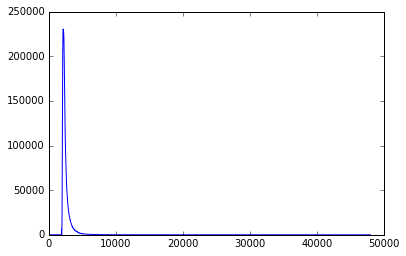

In [7]:
import numpy as np
from scipy.stats import shapiro, anderson, probplot

from matplotlib import pyplot as plt
%matplotlib inline

from lidar_processing import fit_checks; reload(fit_checks)
from lidar_processing import pre_processing; reload(pre_processing)


# Read input data
f = np.loadtxt('../data/pollyxt_raw_signals_160416_0000_to_0229.txt', delimiter=';')

number_of_bins = f.shape[0]
z = np.arange(number_of_bins) * 7.5 + 3.75

signal_355 = f[:, 0]
signal_387 = f[:, 2]
plt.plot(z, signal_355)

### Correct dead time

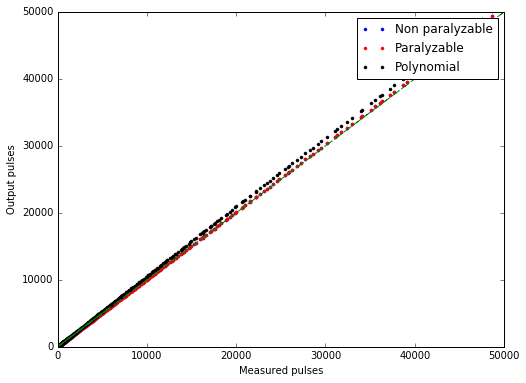

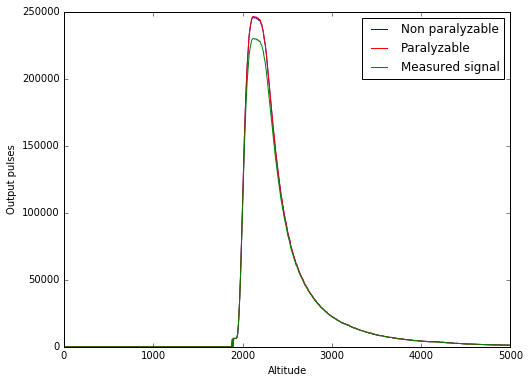

In [8]:
corrected_signal = signal_355

dead_time = 2.5  # ns
duration_per_profile =  50 * 20 * 30  # ns
number_of_profiles = 149 * 2
measurement_interval = duration_per_profile * number_of_profiles


# Non paralyzable
non_paralyzable_corrected = pre_processing.correct_dead_time_nonparalyzable(corrected_signal, 
                                                                            measurement_interval, 
                                                                            dead_time)

# Paralyzable
paralyzable_corrected = pre_processing.correct_dead_time_paralyzable(corrected_signal, 
                                                                     measurement_interval, 
                                                                     dead_time)

# Polynomial
coefficients_355 = [1.83e-8, -3.88e-6, 3.17e-4, -7.289e-3, 1.06092, 0]
polynomial_corrected = pre_processing.correct_dead_time_polynomial_counts(corrected_signal, 
                                                                          coefficients_355,
                                                                          measurement_interval)

plt.figure(figsize=(8, 6))
plt.plot(corrected_signal, non_paralyzable_corrected, 'b.', label='Non paralyzable')
plt.plot(corrected_signal, paralyzable_corrected, 'r.', label='Paralyzable')
plt.plot(corrected_signal, polynomial_corrected, 'k.', label='Polynomial')
plt.plot(corrected_signal, corrected_signal, 'g--')
plt.xlabel('Measured pulses'); plt.ylabel('Output pulses')
lims = (0, 50000); plt.xlim(lims); plt.ylim(lims)
plt.legend()

plt.figure(figsize=(8, 6))
plt.plot(z, non_paralyzable_corrected, 'b', label='Non paralyzable')
plt.plot(z, paralyzable_corrected, 'r', label='Paralyzable')
plt.plot(z, corrected_signal, 'g', label='Measured signal')
plt.xlabel('Altitude'); plt.ylabel('Output pulses')
#lims = (0, 500); plt.xlim(lims); plt.ylim(lims)
plt.xlim(0, 5000)
plt.legend()


## Test corrections in high countrates

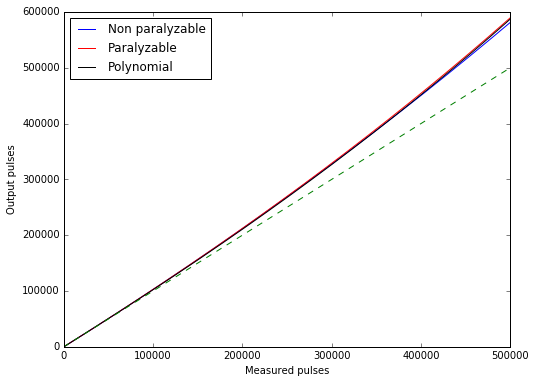

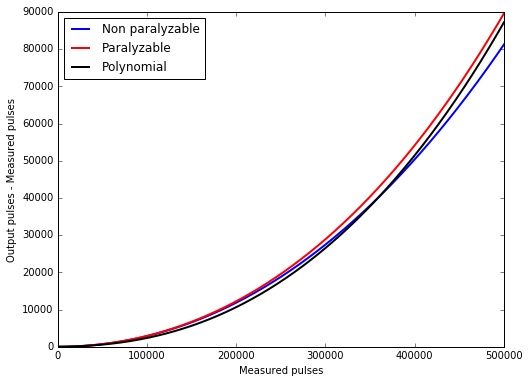

In [9]:
dead_time = 2.5
coefficients_355 = [1.83e-8, -3.88e-6, 3.17e-4, -7.289e-3, 1.06092, 0]
coefficients_532 = [3.88e-9, -5.23e-7, 4.57e-5, 1.486e-3, 1.00197, 0]

test_signal = np.linspace(0, 500000, 1000)
non_paralyzable_test_signal = pre_processing.correct_dead_time_nonparalyzable(test_signal, 
                                                                            measurement_interval, 
                                                                            dead_time)

paralyzable_test_signal = pre_processing.correct_dead_time_paralyzable(test_signal, 
                                                                     measurement_interval, 
                                                                     dead_time)


polynomial_test_signal = pre_processing.correct_dead_time_polynomial_counts(test_signal, 
                                                                          coefficients_532,
                                                                          measurement_interval)

plt.figure(figsize=(8, 6))
plt.plot(test_signal, non_paralyzable_test_signal, 'b', label='Non paralyzable')
plt.plot(test_signal, paralyzable_test_signal, 'r', label='Paralyzable')
plt.plot(test_signal, polynomial_test_signal, 'k', label='Polynomial')
plt.plot(test_signal, test_signal, 'g--')
plt.xlabel('Measured pulses'); plt.ylabel('Output pulses')
#lims = (0, 500); plt.xlim(lims); plt.ylim(lims)
plt.legend(loc=2)

plt.figure(figsize=(8, 6))
plt.plot(test_signal, non_paralyzable_test_signal - test_signal, 'b', lw=2, label='Non paralyzable')
plt.plot(test_signal, paralyzable_test_signal- test_signal, 'r', lw=2, label='Paralyzable')
plt.plot(test_signal, polynomial_test_signal- test_signal, 'k', lw=2, label='Polynomial')
#plt.plot(test_signal, test_signal, 'g--')
plt.xlabel('Measured pulses'); plt.ylabel('Output pulses - Measured pulses')
#lims = (0, 500); plt.xlim(lims); plt.ylim(lims)
plt.legend(loc=2)

### Background subtraction

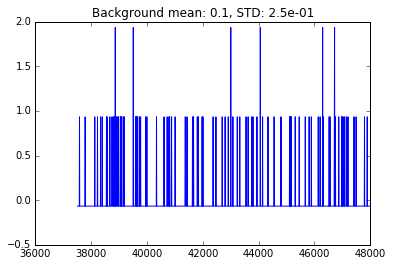

In [10]:
# Background subtracted photon
backround_removed_signal,background_mean, background_std = \
        pre_processing.subtract_background(non_paralyzable_corrected, idx_min=10, idx_max=160)

idx_min = 5000
plt.plot(z[idx_min:], backround_removed_signal[idx_min:])
plt.title('Background mean: %2.1f, STD: %2.1e' % (background_mean, background_std))


### Trigger delay

(0, 100)

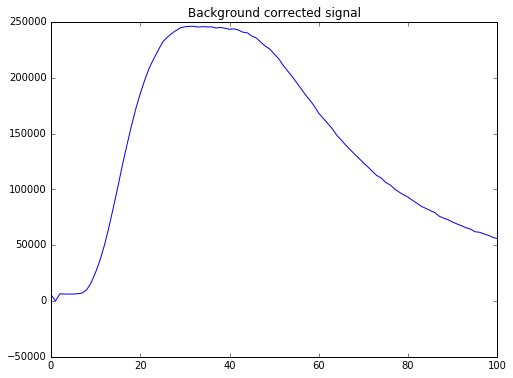

In [11]:
# Integer bin shift
trigger_delay_bin = -251
trigger_delay_signal_bins = pre_processing.correct_trigger_delay_bins(backround_removed_signal, trigger_delay_bin)

plt.figure(figsize=(8, 6))
plt.plot(trigger_delay_signal_bins)
plt.title("Background corrected signal")
plt.xlim(0, 100)

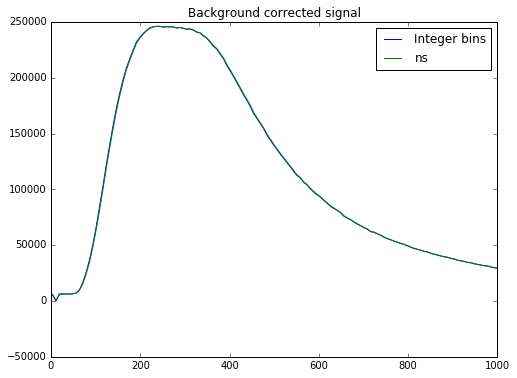

In [12]:
# Ns shift (fractional bins)
trigger_delay_ns = -251 * 50.  # bins * ns
trigger_delay_signal_ns = pre_processing.correct_trigger_delay_ns(backround_removed_signal, 
                                                           z, trigger_delay_ns)

# Correct trigger delay
range_corrected_signal_td_ns = pre_processing.apply_range_correction(trigger_delay_signal_ns, z)
range_corrected_signal_bins = pre_processing.apply_range_correction(trigger_delay_signal_bins, z)

idx_max = 4000

plt.figure(figsize=(8, 6))
plt.plot(z[:idx_max], trigger_delay_signal_bins[:idx_max], label='Integer bins')
plt.plot(z[:idx_max], trigger_delay_signal_ns[:idx_max], label='ns')
plt.legend()
plt.xlim(0, 1000)
#plt.ylim(0.02, 0.1)
#plt.yscale('log')
plt.title("Background corrected signal")
